# Learning to Outperform Barker

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt

from comms import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

We will base using the same barker sequence as the last notebook for baseline.

In [2]:
barker_seq = [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1]
len(barker_seq)

bpsk_scheme = [-1+0j, 1+0j]
preamble = np.array([bpsk_scheme[i] for i in barker_seq])

## The FCN architecture

Since we know that a single FCN layer can learn our sequence, let's try increasing the number of filters, as well as layers.

In [3]:
class preamble_detector(nn.Module):
    def __init__(self):
        super(preamble_detector, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, (2,13), 1, padding=(0,6))
        self.conv2 = nn.Conv2d(16, 16, (1,13), 1, padding=(0,6))
        
        self.conv3 = nn.Conv2d(16,1,1,1)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        x= self.conv3(x)
        
        # Output only 1 dimension
        x = x.squeeze()

        return x

Also let's generate a more comprehensive training set.

In [4]:
def gen_training_data(num_examples = 1024, payload= 128, signal_length = 200, snr = 10, add_phase_offset=True, gpu=True):

    # Pre-define array to contain complex-valued waveforms
    waveforms = np.zeros((num_examples,signal_length),dtype=np.complex128)

    # Predefine labels array
    labels = np.zeros((num_examples,),dtype=int)

    # Generate random payload bits
    bits = np.random.randint(0,2,(num_examples,payload))

    # Add preambles to payloads
    packet = np.concatenate((np.tile(barker_seq,(num_examples,1)), bits), axis=1)

    # Map to BPSK symbols
    packet = np.where(packet < 1, -1+0j, 1+0j)

    # Insert into random offset and save offset as label
    for idx, waveform in enumerate(waveforms):
        offset = np.random.randint(20,60)
        waveform[offset:offset+payload+len(preamble)] = packet[idx]
        if add_phase_offset:
            waveforms[idx] = phase_offset(waveform,offset=np.random.randint(-180,high=181))
        else:
            waveforms[idx] = waveform
        labels[idx] = offset    

    # Add noise
    waveforms = awgn(waveforms,snr)

    # Convert labels to pytorch tensors
    labels_oh = np.zeros((num_examples,signal_length))
    for idx, label in enumerate(labels):
        labels_oh[idx,label] = 1
    labels = torch.FloatTensor(labels_oh)
    # labels = torch.LongTensor(labels)

    # Split into real and imaginary channels
    train_data = torch.FloatTensor(np.expand_dims(np.stack((waveforms.real, waveforms.imag),axis=1),axis=1))

    # Prep dataset for cuda if gpu true
    if gpu:
        train_data = train_data.cuda()
        labels = labels.cuda()
        
    return train_data, labels

pytorch dataloaders very convenient -- automatic batching and shuffling

In [5]:
# training data
train_data, labels = gen_training_data(num_examples = 8192, payload= 128, signal_length = 200, snr = 5, gpu=True)

train_dataset = torch.utils.data.TensorDataset(train_data, labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# validation data
val_data, val_labels = gen_training_data(num_examples = 128, payload= 128, signal_length = 200, snr = 5, add_phase_offset=False, gpu=True)

val_dataset = torch.utils.data.TensorDataset(val_data, val_labels)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

Simple training loop, MSE is fine for this regression problem

In [6]:
detector = preamble_detector()
detector.cuda()

loss_fn = nn.MSELoss()
optimizer = optim.Adam(detector.parameters(), lr=0.001)

losses = []
val_losses = []

num_epochs = 10

for epoch in range(num_epochs):  # loop over the dataset multiple times
    
    running_loss, running_val_loss = 0, 0
    
    for x_train, y_train in train_loader:
    
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = detector(x_train)
        loss = loss_fn(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    losses.append(running_loss/len(train_loader))
    
    with torch.no_grad():
        # evaluate validation loss
        for x_val, y_val in val_loader:
            val_outputs = detector(x_val)
            val_loss = loss_fn(val_outputs, y_val)

            running_val_loss += val_loss.item()
    
    val_losses.append(running_val_loss/len(val_loader))

    print(f"Epoch {epoch}: loss: {losses[-1]}, val_loss: {val_losses[-1]}")

Epoch 0: loss: 0.0041466080574537045, val_loss: 0.001285992591874674
Epoch 1: loss: 0.0004929002097355806, val_loss: 0.0003076774228247814
Epoch 2: loss: 0.00029159405482914735, val_loss: 0.00026427890770719387
Epoch 3: loss: 0.00025068342887379913, val_loss: 0.00023472430257243104
Epoch 4: loss: 0.0002195760645804512, val_loss: 0.00020677126667578705
Epoch 5: loss: 0.00019466068363271916, val_loss: 0.0001856810431490885
Epoch 6: loss: 0.0001677445509926656, val_loss: 0.00016664446593495086
Epoch 7: loss: 0.00013502798799436277, val_loss: 0.00012623550719581544
Epoch 8: loss: 9.645825306847655e-05, val_loss: 9.126211170951137e-05
Epoch 9: loss: 6.1773779130192e-05, val_loss: 5.611463257082505e-05


We can see that the convergence happened super fast on our tiny model and dataset.

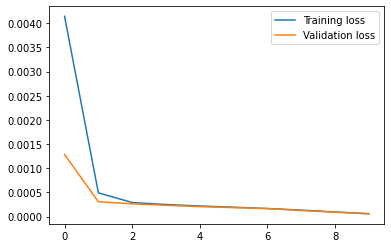

In [7]:
plt.plot(losses)
plt.plot(val_losses)
plt.legend(['Training loss', 'Validation loss'])
plt.show()

Now try deploying it on some frames

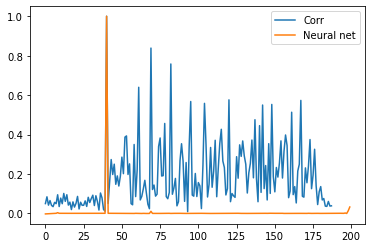

In [8]:
detector.cpu()

waveform = awgn(create_frame(barker_seq),10)
my_frame = torch.FloatTensor(np.expand_dims(np.vstack((waveform.real, waveform.imag)),axis=(0,1)))

y = detector(my_frame)
correlation = np.abs(np.correlate(waveform, preamble, mode='valid'))
plt.plot(correlation/np.max(correlation))
plt.plot((y/torch.max(y)).detach().numpy())
plt.legend(('Corr','Neural net'))

It also works on multiple packets

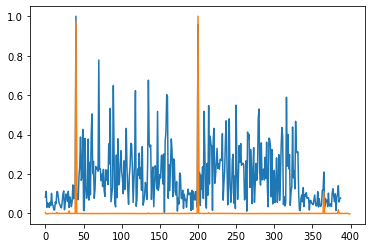

In [9]:
# Create multipacket waveform
waveform = np.concatenate((create_frame(barker_seq, offset=40,payload=128), create_frame(barker_seq, offset=0,payload=128)))
my_frame = awgn(waveform,10)

correlation = np.abs(np.correlate(my_frame, preamble, mode='valid'))  

# Pre-process
new_frame = np.expand_dims(np.vstack((my_frame.real, my_frame.imag)),axis=(0,1))
new_frame = torch.tensor(new_frame).float()

# Find index with neural network
nn_output = detector(new_frame).detach().numpy()
y_nn = np.argmax(nn_output)

plt.plot(correlation/np.max(correlation))
plt.plot(nn_output/np.max(nn_output))

Ain't that neat? Couldn't do this with a regular CNN. With an FCN we just pipe signals through this thing like a normal filter.

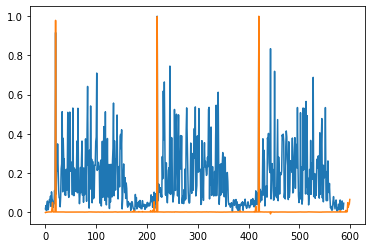

In [10]:
# Create multipacket waveform
waveform = np.concatenate((create_frame(barker_seq, offset=20,payload=128), create_frame(barker_seq, offset=20,payload=128), create_frame(barker_seq, offset=20,payload=128)))
my_frame = awgn(waveform,15)

correlation = np.abs(np.correlate(my_frame, preamble, mode='valid'))  

# Pre-process
new_frame = np.expand_dims(np.vstack((my_frame.real, my_frame.imag)),axis=(0,1))
new_frame = torch.tensor(new_frame).float()

# Find index with neural network
nn_output = detector(new_frame).detach().numpy()
y_nn = np.argmax(nn_output)

plt.plot(correlation/np.max(correlation))
plt.plot(nn_output/np.max(nn_output))

## Measuring Detection Error Rate

First define a baseline DER for our barker sequence, so we know what we are trying to beat.

In [11]:
def calculate_baseline(preamble_seq, snr_range, num_iter=1500, payload=128,
                       signal_length=200, add_phase_offset=True):
    
    preamble = np.where(preamble_seq < 1, -1+0j, 1+0j)

    corr_ers = np.zeros(len(snr_range),)

    for idx, snr in enumerate(snr_range):
        corr_err = float(0)
        for i in range(num_iter):

            # Create new frame with a random tau
            tau = np.random.randint(0,signal_length-payload-len(preamble_seq))
            my_frame = create_frame(preamble_seq, payload=payload, signal_length=signal_length, offset=tau)
            
            if add_phase_offset:
                ph = np.random.randint(-180,high=181)
                my_frame = phase_offset(my_frame, offset=ph)
                
            # Add noise
            my_frame = awgn(my_frame, snr)
            
            # Find peaks using correlation
            correlation = np.abs(np.correlate(my_frame, preamble, mode='valid'))
            y_corr = np.argmax(correlation)

            # Calculate if error
            corr_err = corr_err + (y_corr != tau)

        corr_ers[idx] = corr_err
  
    corr_ders = corr_ers/num_iter
        
    return corr_ders

It's typical to plot DER on a logarithmic scale, over a range of SNR values.

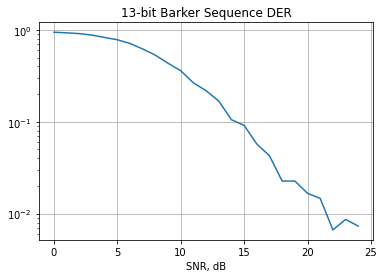

In [12]:
snr_range = np.arange(-15,10)
baseline_ders = calculate_baseline(np.array(barker_seq), snr_range=snr_range, num_iter=1500, payload=64)

plt.semilogy(baseline_ders)
plt.title('13-bit Barker Sequence DER')
plt.xlabel('SNR, dB')
plt.grid()

Similarly define a funtion for our neural network as well, it just requires a few more pre-processing steps like normalization and dimensionality manipulation.

In [13]:
# Returns DER for given pytorch detector, make sure trained detector matches the
# preamble you are testing against
def test_detector(detector, preamble_seq, snr_range, num_iter=1500, payload=128, 
                  signal_length=200, add_phase_offset=True, normalize=True):

    nn_ers = np.zeros(len(snr_range),)
    
    for idx, snr in enumerate(snr_range):
        nn_err = float(0)
        for i in range(num_iter):
            
            # Create new frame with a random tau
            tau = np.random.randint(0,signal_length-payload-len(preamble_seq))
            my_frame = create_frame(preamble_seq, payload=payload, signal_length=signal_length, offset=tau)
    
            if add_phase_offset:
                ph = np.random.randint(-180,high=181)
                my_frame = phase_offset(my_frame, offset=ph)
                
            # Add noise
            my_frame = awgn(my_frame, snr)
            
            # normalize
            if normalize:
                my_frame = my_frame/np.max(np.abs(my_frame))

            # FCN prediction
            new_frame = np.expand_dims(np.vstack((my_frame.real, my_frame.imag)),axis=(0,1))
            new_frame = torch.tensor(new_frame).float()
            nn_output = detector(new_frame)

            y_nn = torch.argmax(nn_output)

            # Calculate if error
            nn_err = nn_err + (y_nn != tau)

        nn_ers[idx] = nn_err

    nn_ders = nn_ers/num_iter
        
    return nn_ders

In [14]:
nn_ders = test_detector(detector, barker_seq, snr_range, add_phase_offset=False, num_iter=1500, payload=64)

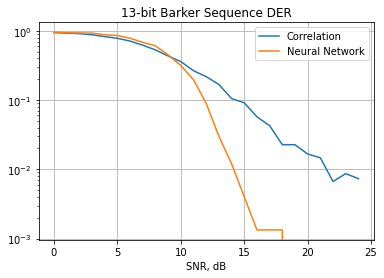

In [15]:
plt.semilogy(baseline_ders)
plt.semilogy(nn_ders)
plt.title('13-bit Barker Sequence DER')
plt.xlabel('SNR, dB')
plt.legend(('Correlation', 'Neural Network'))
plt.grid()

If you come from a more ML-focused field, then you will probably be more used to seeing accuracy as the main performance metric. We can easily convert between DER and accuracy by just subtracting the DER from 1. Accuracy is also a useful measure to look at as you do not need as many samples to reproduce an interpretable DER curve and can still use this information to gain insight on how training is going.

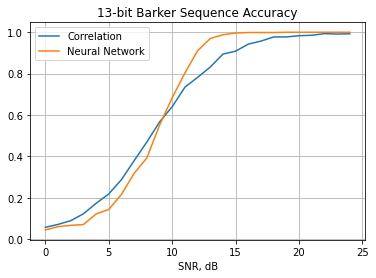

In [16]:
plt.plot(1-baseline_ders)
plt.plot(1-nn_ders)

plt.title('13-bit Barker Sequence Accuracy')
plt.xlabel('SNR, dB')
plt.legend(('Correlation', 'Neural Network'))
plt.grid()

Simple! We're now outperforming Barker from 10dB onwards. Try lowering the training SNR and see if you can beat it over the entire SNR range.